In [29]:
# SECTION 1: SETUP & IMPORTS

# Core ML
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
import warnings
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler


# System and Warnings
import warnings
warnings.filterwarnings("ignore")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [48]:
# Configurations
IMG_SIZE = 128
VOLUME_SLICES = 50
VOLUME_START_AT = 22
BATCH_SIZE = 1
NUM_EPOCHS = 5
NUM_ROUNDS = 1
batch_size = 1  # stable
pin_memory = True
num_workers = 4  # or os.cpu_count() // 2



In [49]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.patient_dirs = sorted(os.listdir(root_dir))
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_id = self.patient_dirs[idx]
        patient_path = os.path.join(self.root_dir, patient_id)

        # Load MRI modalities
        modalities = ['t1c', 't1n', 't2f', 't2w']
        image_data = []
        for mod in modalities:
            image_path = os.path.join(patient_path, f"{patient_id}-{mod}.nii")
            image = nib.load(image_path).get_fdata()
            image_data.append(image)

        image_np = np.stack(image_data, axis=0).astype(np.float32)
        image_tensor = torch.tensor(image_np, dtype=torch.float32)

        # Load label if in training mode
        if self.train:
            label_path = os.path.join(patient_path, f"{patient_id}-seg.nii")
            label_np = nib.load(label_path).get_fdata().astype(np.uint8)
            label_np[label_np == 4] = 3  # Map 4→3 to maintain 4-class system
            label_tensor = torch.from_numpy(label_np).long().unsqueeze(0)
        else:
            label_tensor = None

        # Apply TorchIO transform
        if self.transform:
            subject_dict = {"images": tio.ScalarImage(tensor=image_tensor)}
            if label_tensor is not None:
                subject_dict["label"] = tio.LabelMap(tensor=label_tensor)
            subject = tio.Subject(**subject_dict)
            transformed = self.transform(subject)
            image_tensor = transformed.images.data
            if label_tensor is not None:
                label_tensor = transformed.label.data

        return (image_tensor, label_tensor) if self.train else image_tensor


In [50]:
# CELL 3: TorchIO Preprocessing Transform

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensities to [0, 1]
    tio.Resize((128, 128, 128)),               # Resize to fixed shape
    tio.ZNormalization()                       # Normalize mean=0, std=1
])


In [51]:
augment_transform = tio.Compose([
    # Intensity-based
    tio.RandomBiasField(p=0.3),
    tio.RandomGamma(p=0.3),
    tio.RandomNoise(p=0.2),
    
    # Spatial-based
    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=10,
        translation=5,
        center='image',
        p=0.5
    ),
    tio.RandomElasticDeformation(p=0.2),
    tio.RandomFlip(axes=('LR',), p=0.5),

    # Preprocessing
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((128, 128, 128)),
    tio.ZNormalization()
])


In [67]:
# CELL 4: Client Dataset Paths and Loaders

# Define paths (adjust as needed to match your directory structure)
Hospital1_Train = 'Data/2023GLI/TrainingData'
Hospital1_Val   = 'Data/2023GLI/ValidationData'
Hospital2_Train = 'Data/2023MEN/TrainingData'
Hospital2_Val   = 'Data/2023MEN/ValidationData'
Hospital3_Train = 'Data/2023MET/TrainingData'
Hospital3_Val   = 'Data/2023MET/ValidationData'
Hospital4_Train = 'Data/2023PED/TrainingData'
Hospital4_Val   = 'Data/2023PED/ValidationData'
Hospital5_Train = 'Data/2023SSA/TrainingData'
Hospital5_Val   = 'Data/2023SSA/ValidationData'
Hospital6_Train_Val = 'Data/BraTS2021'
Hospital7_Train = 'Data/BraTS2020/TrainingData'
Hospital7_Val   = 'Data/BraTS2020/ValidationData'
Hospital8_Train_Val = 'Data/BraTS2019/HGG'
Hospital9_Train_Val = 'Data/BraTS2019/LGG'

hospitals = {
    "Hospital1": {"train": Hospital1_Train, "val": Hospital1_Val},
    "Hospital2": {"train": Hospital2_Train, "val": Hospital2_Val},
    "Hospital3": {"train": Hospital3_Train, "val": Hospital3_Val},
    "Hospital4": {"train": Hospital4_Train, "val": Hospital4_Val},
    "Hospital5": {"train": Hospital5_Train, "val": Hospital5_Val},
    "Hospital6": {"combined": Hospital6_Train_Val},
    "Hospital7": {"train": Hospital7_Train, "val": Hospital7_Val},
    "Hospital8": {"combined": Hospital8_Train_Val},
    "Hospital9": {"combined": Hospital9_Train_Val}
}

hospital_loaders = {}
train_ratio = 0.8
batch_size = 1

for hospital, paths in hospitals.items():
    print(f"🔁 Loading {hospital}...")

    if "combined" in paths:
        full_dataset = BraTSDataset(paths["combined"], transform=transform, train=True)
        train_size = int(train_ratio * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])
    else:
        train_set = BraTSDataset(paths["train"], transform=transform, train=True)
        val_set = BraTSDataset(paths["val"], transform=transform, train=False)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

    hospital_loaders[hospital] = {
        "train": train_loader,
        "val": val_loader
    }

print("\n✅ All hospital loaders are ready.")


🔁 Loading Hospital1...
🔁 Loading Hospital2...
🔁 Loading Hospital3...
🔁 Loading Hospital4...
🔁 Loading Hospital5...
🔁 Loading Hospital6...
🔁 Loading Hospital7...
🔁 Loading Hospital8...
🔁 Loading Hospital9...

✅ All hospital loaders are ready.


Input shape: torch.Size([1, 4, 128, 128, 128]) | Label shape: torch.Size([1, 1, 128, 128, 128])


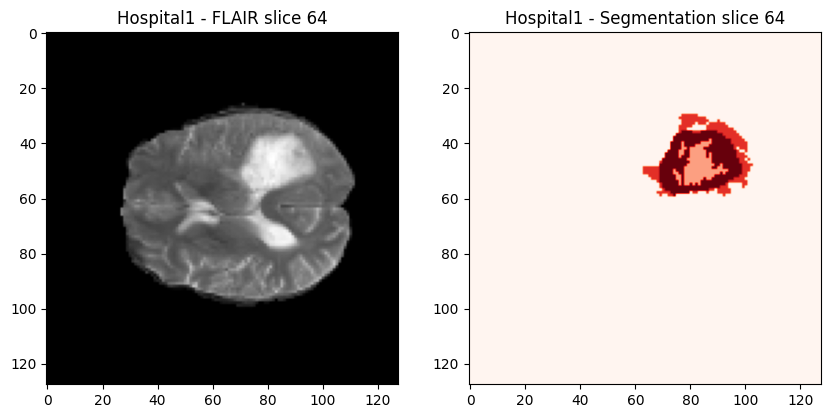

In [68]:
# CELL 5: Visualize Sample Volume + Mask Slice

import random

def visualize_random_sample(hospital="Hospital1", slice_idx=64):
    loader = hospital_loaders[hospital]["train"]
    image, label = next(iter(loader))

    print(f"Input shape: {image.shape} | Label shape: {label.shape}")
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Show slice from FLAIR (assume channel 3)
    axs[0].imshow(image[0, 3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{hospital} - FLAIR slice {slice_idx}")

    # Corresponding segmentation mask slice
    axs[1].imshow(label[0, 0, :, :, slice_idx].cpu(), cmap='Reds')
    axs[1].set_title(f"{hospital} - Segmentation slice {slice_idx}")

    plt.show()

# Example call
visualize_random_sample("Hospital1", slice_idx=64)


In [70]:
print("\n📊 Dataset sizes per hospital:")
for hospital, loaders in hospital_loaders.items():
    train_size = len(loaders['train'].dataset)
    val_size = len(loaders['val'].dataset)
    print(f"{hospital} → Train: {train_size} | Val: {val_size}")



📊 Dataset sizes per hospital:
Hospital1 → Train: 1251 | Val: 219
Hospital2 → Train: 1000 | Val: 141
Hospital3 → Train: 165 | Val: 31
Hospital4 → Train: 99 | Val: 45
Hospital5 → Train: 60 | Val: 15
Hospital6 → Train: 1000 | Val: 251
Hospital7 → Train: 369 | Val: 125
Hospital8 → Train: 207 | Val: 52
Hospital9 → Train: 60 | Val: 16


In [71]:
# CELL 7: Fixed TwinSegNet Model (ViT + UNet Hybrid)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Resize skip connection if needed
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='trilinear', align_corners=False)
        x = torch.cat((x, skip), dim=1)
        return self.conv(x)


class PatchEmbedViT(nn.Module):
    def __init__(self, in_channels=128, embed_dim=256, patch_size=2):
        super(PatchEmbedViT, self).__init__()
        self.patch_embed = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, embed_dim, 1, 1, 1))  # minimal shape

    def forward(self, x):
        x = self.patch_embed(x)
        if x.shape[2:] != self.pos_embed.shape[2:]:
            pos_embed = F.interpolate(self.pos_embed, size=x.shape[2:], mode='trilinear', align_corners=False)
        else:
            pos_embed = self.pos_embed
        return x + pos_embed


class TwinSegNet(nn.Module):
    def __init__(self, in_channels=4, n_classes=3, base_channels=32):
        super(TwinSegNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, base_channels)              # 128
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)        # 64
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)    # 32
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = ConvBlock(base_channels * 4, base_channels * 8)    # 16
        self.pool4 = nn.MaxPool3d(2)

        # ViT at bottleneck
        self.vit = PatchEmbedViT(in_channels=base_channels * 8, embed_dim=base_channels * 16, patch_size=2)
        self.vit_proj = nn.Conv3d(base_channels * 16, base_channels * 8, kernel_size=1)

        # Decoder (UNet-style)
        self.up4 = UpBlock(base_channels * 8, base_channels * 4, base_channels * 4)  # match enc3
        self.up3 = UpBlock(base_channels * 4, base_channels * 2, base_channels * 2)  # match enc2
        self.up2 = UpBlock(base_channels * 2, base_channels, base_channels)          # match enc1
        self.final_conv = nn.Conv3d(base_channels, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)                # [B, 32, 128,128,128]
        e2 = self.enc2(self.pool1(e1))   # [B, 64, 64,64,64]
        e3 = self.enc3(self.pool2(e2))   # [B, 128, 32,32,32]
        e4 = self.enc4(self.pool3(e3))   # [B, 256, 16,16,16]
        b = self.pool4(e4)               # [B, 256, 8,8,8]

        b = self.vit(b)                  # [B, 512, 4,4,4] → [B, 256, 4,4,4]
        b = self.vit_proj(b)             # [B, 256, 4,4,4]

        d4 = self.up4(b, e3)             # [B, 128, 8,8,8]
        d3 = self.up3(d4, e2)            # [B, 64, 16,16,16]
        d2 = self.up2(d3, e1)            # [B, 32, 32,32,32]
        out = self.final_conv(d2)        # [B, n_classes, 32,32,32]

        return out


In [72]:
def dice_loss(pred, target, epsilon=1e-6):
    """
    pred: (B, C, D, H, W)
    target: (B, 1, D', H', W') → label mask
    """
    pred = torch.softmax(pred, dim=1)

    # Resize target to match pred spatial shape
    if target.shape[2:] != pred.shape[2:]:
        target = F.interpolate(target.float(), size=pred.shape[2:], mode='nearest')

    # One-hot encode
    target = target.squeeze(1).long()  # (B, D, H, W)
    target = F.one_hot(target, num_classes=pred.shape[1])  # (B, D, H, W, C)
    target = target.permute(0, 4, 1, 2, 3).float()          # (B, C, D, H, W)

    # Dice computation
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2 * intersection + epsilon) / (union + epsilon)

    return 1 - dice.mean()


In [74]:
import gc
import torch

def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print(f"🧹 GPU memory cleared. Available: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


In [75]:
!nvidia-smi
!fuser -v /dev/nvidia0  # see PIDs using the GPU


Sun Apr 27 13:26:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:21:00.0  On |                  N/A |
|  0%   54C    P8             38W /  320W |    1363MiB /  10240MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [76]:
!kill -9 <3013>


/bin/bash: -c: line 1: syntax error near unexpected token `3013'
/bin/bash: -c: line 1: `kill -9 <3013>'


In [77]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [91]:
client_devices = {
    "Hospital1": "cuda:1",
    "Hospital2": "cuda:1",
    "Hospital3": "cuda:1",
    "Hospital4": "cuda:1",
    "Hospital5": "cuda:1",
    "Hospital6": "cuda:1",
    "Hospital7": "cuda:1",
    "Hospital8": "cuda:1",
    "Hospital9": "cuda:1",
    
}


In [101]:
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    dices = []
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, tuple):
                images, masks = batch
            else:
                # If validation set has no labels
                images = batch
                print("⚠️ Warning: Validation data has no labels! Skipping.")
                continue

            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            masks = masks.squeeze(1)
            preds = preds.squeeze(1)

            intersection = (preds == masks).float().sum()
            union = preds.numel()

            dice_score = (2. * intersection) / (union + 1e-6)
            dices.append(dice_score.item())

    if len(dices) == 0:
        print("⚠️ No valid labels available for evaluation.")
        return 0.0

    avg_dice = np.mean(dices)
    return avg_dice


In [102]:

# def train_one_client(model, dataloader, optimizer, epochs=1, client_name="", device="cuda"):
#     model.train()
#     model.to(device)
#     total_loss = 0

#     scaler = GradScaler()

#     for epoch in range(epochs):
#         epoch_loss = 0
#         print(f"\n🚀 [{client_name}] Epoch {epoch+1}/{epochs} — Training {len(dataloader)} batches")

#         for i, (images, masks) in enumerate(dataloader):
#             images, masks = images.to(device), masks.to(device)

#             optimizer.zero_grad()

#             with autocast():
#                 outputs = model(images)
#                 loss = dice_loss(outputs, masks)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             print(f"   📦 Batch {i+1}/{len(dataloader)} — Loss: {loss.item():.4f} — "
#                   f"Mem: {torch.cuda.memory_allocated(device) / 1e6:.1f} MB")

#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         total_loss += avg_loss

#         # 🧪 Evaluate after each epoch
#         val_loader = hospital_loaders[client_name]["val"]
#         dice = evaluate_model(model, val_loader, device)

#         print(f"✅ [{client_name}] Epoch {epoch+1} Complete — Avg Loss: {avg_loss:.4f} | Val Dice: {dice:.4f}")

#     return model.state_dict()


In [103]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_client(model, dataloader, optimizer, epochs=1, client_name="", device="cuda"):
    model.train()
    model.to(device)
    total_loss = 0

    for epoch in range(epochs):
        epoch_loss = 0
        print(f"\n🚀 [{client_name}] Epoch {epoch+1}/{epochs} — Training {len(dataloader)} batches")

        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = dice_loss(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            print(f"   📦 Batch {i+1}/{len(dataloader)} — Loss: {loss.item():.4f} — "
                  f"Mem: {torch.cuda.memory_allocated(device) / 1e6:.1f} MB")

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        total_loss += avg_loss
        print(f"✅ [{client_name}] Epoch {epoch+1} Complete — Avg Loss: {avg_loss:.4f}")

    return model.state_dict()


In [104]:
def train_clients_round(client_names, hospital_loaders, base_model_fn, epochs=1, lr=1e-4):
    updated_weights = {}
    for client in client_names:
        device = client_devices[client]
        print(f"🔥 Training {client} on {device}")

        model = base_model_fn().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        train_loader = hospital_loaders[client]["train"]

        weights = train_one_client(model, train_loader, optimizer,
                                   epochs=epochs, client_name=client, device=device)
        updated_weights[client] = weights
    return updated_weights


In [86]:
# Example: Training Hospital1

client_name = "Hospital3"
device = client_devices[client_name]

model = TwinSegNet(in_channels=4, n_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loader = hospital_loaders[client_name]["train"]

# 🔁 Call the training function
new_weights = train_one_client(
    model=model,
    dataloader=train_loader,
    optimizer=optimizer,
    epochs=1,
    client_name=client_name,
    device=device
)



🚀 [Hospital3] Epoch 1/1 — Training 165 batches
   📦 Batch 1/165 — Loss: 0.9068 — Mem: 372.8 MB
   📦 Batch 2/165 — Loss: 0.9119 — Mem: 372.8 MB
   📦 Batch 3/165 — Loss: 0.9092 — Mem: 372.8 MB
   📦 Batch 4/165 — Loss: 0.8970 — Mem: 372.8 MB
   📦 Batch 5/165 — Loss: 0.9014 — Mem: 372.8 MB
   📦 Batch 6/165 — Loss: 0.8871 — Mem: 372.8 MB
   📦 Batch 7/165 — Loss: 0.8923 — Mem: 372.8 MB
   📦 Batch 8/165 — Loss: 0.8999 — Mem: 372.8 MB
   📦 Batch 9/165 — Loss: 0.9001 — Mem: 372.8 MB
   📦 Batch 10/165 — Loss: 0.8768 — Mem: 372.8 MB
   📦 Batch 11/165 — Loss: 0.8799 — Mem: 372.8 MB
   📦 Batch 12/165 — Loss: 0.8690 — Mem: 372.8 MB
   📦 Batch 13/165 — Loss: 0.8998 — Mem: 372.8 MB
   📦 Batch 14/165 — Loss: 0.8974 — Mem: 372.8 MB
   📦 Batch 15/165 — Loss: 0.8731 — Mem: 372.8 MB
   📦 Batch 16/165 — Loss: 0.8580 — Mem: 372.8 MB
   📦 Batch 17/165 — Loss: 0.8877 — Mem: 372.8 MB
   📦 Batch 18/165 — Loss: 0.8900 — Mem: 372.8 MB
   📦 Batch 19/165 — Loss: 0.8922 — Mem: 372.8 MB
   📦 Batch 20/165 — Loss: 0.86

In [95]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [96]:

import gc
gc.collect()
torch.cuda.empty_cache()


In [97]:
torch.cuda.memory_summary()


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 238722 KiB |   1612 MiB |  24052 GiB |  24052 GiB |\n|       from large pool | 192384 KiB |   1541 MiB |  23809 GiB |  23809 GiB |\n|       from small pool |  46338 KiB |     73 MiB |    242 GiB |    242 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 238722 KiB |   1612 MiB |  24052 GiB |  24052 GiB |\n|       from large pool | 192384 KiB |   1541 MiB |

In [22]:
# This trains all specified clients in one FL round
clients_to_train = ["Hospital1", "Hospital2"]  # or more
def build_model(): return TwinSegNet(in_channels=4, n_classes=4)

client_weights = train_clients_round(
    client_names=clients_to_train,
    hospital_loaders=hospital_loaders,
    base_model_fn=build_model,
    epochs=2
)


🔥 Training Hospital1 on cuda:0

🚀 [Hospital1] Epoch 1/2 — Training 1251 batches
   📦 Batch 1/1251 — Loss: 0.8887 — Mem: 318.5 MB
   📦 Batch 2/1251 — Loss: 0.8807 — Mem: 318.5 MB
   📦 Batch 3/1251 — Loss: 0.8797 — Mem: 318.5 MB
   📦 Batch 4/1251 — Loss: 0.8778 — Mem: 318.5 MB
   📦 Batch 5/1251 — Loss: 0.8818 — Mem: 318.5 MB
   📦 Batch 6/1251 — Loss: 0.8852 — Mem: 318.5 MB
   📦 Batch 7/1251 — Loss: 0.8781 — Mem: 318.5 MB
   📦 Batch 8/1251 — Loss: 0.8725 — Mem: 318.5 MB
   📦 Batch 9/1251 — Loss: 0.8766 — Mem: 318.5 MB
   📦 Batch 10/1251 — Loss: 0.8766 — Mem: 318.5 MB
   📦 Batch 11/1251 — Loss: 0.8787 — Mem: 318.5 MB
   📦 Batch 12/1251 — Loss: 0.8675 — Mem: 318.5 MB
   📦 Batch 13/1251 — Loss: 0.8706 — Mem: 318.5 MB
   📦 Batch 14/1251 — Loss: 0.8781 — Mem: 318.5 MB
   📦 Batch 15/1251 — Loss: 0.8631 — Mem: 318.5 MB
   📦 Batch 16/1251 — Loss: 0.8628 — Mem: 318.5 MB
   📦 Batch 17/1251 — Loss: 0.8680 — Mem: 318.5 MB
   📦 Batch 18/1251 — Loss: 0.8759 — Mem: 318.5 MB
   📦 Batch 19/1251 — Loss: 0.

In [98]:
def fed_avg(client_weights):
    """
    client_weights: dict of {client_name: state_dict}
    returns: averaged global model weights
    """
    global_model = {}

    for k in next(iter(client_weights.values())).keys():
        global_model[k] = torch.stack([weights[k].float() for weights in client_weights.values()], dim=0).mean(dim=0)

    return global_model


In [105]:
# After training all clients
global_weights = fed_avg(client_weights)

# To load global model:
model.load_state_dict(global_weights)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [99]:
def federated_training_rounds(
    client_names, 
    hospital_loaders, 
    base_model_fn, 
    num_rounds=2, 
    local_epochs=1, 
    lr=1e-4,
    device_mapping=None
):
    """
    client_names: list of client IDs
    hospital_loaders: dictionary of data loaders
    base_model_fn: function to instantiate model
    num_rounds: number of FL rounds
    local_epochs: number of epochs at each client per round
    lr: learning rate
    device_mapping: client_name → device
    """

    # Initialize global model
    global_model = base_model_fn()
    global_weights = global_model.state_dict()

    history = {"round": [], "global_val_dice": []}

    for rnd in range(1, num_rounds + 1):
        print(f"\n🌍 Federated Round {rnd}/{num_rounds}")

        client_weights = {}

        # Local training for each client
        for client in client_names:
            print(f"\n🔹 Training Client: {client}")
            device = device_mapping.get(client, "cuda:0")

            model = base_model_fn().to(device)
            model.load_state_dict(global_weights)  # Start from global model
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_loader = hospital_loaders[client]["train"]

            # Train locally
            new_weights = train_one_client(
                model, train_loader, optimizer,
                epochs=local_epochs,
                client_name=client,
                device=device
            )
            client_weights[client] = new_weights

        # 🔀 Aggregate weights (FedAvg)
        global_weights = fed_avg(client_weights)

        # ✅ Evaluate global model
        global_model.load_state_dict(global_weights)
        dice_scores = []

        for client in client_names:
            device = device_mapping.get(client, "cuda:0")
            val_loader = hospital_loaders[client]["val"]
            dice = evaluate_model(global_model.to(device), val_loader, device=device)
            dice_scores.append(dice)
            print(f"📈 Validation Dice on {client}: {dice:.4f}")

        avg_dice = np.mean(dice_scores)
        history["round"].append(rnd)
        history["global_val_dice"].append(avg_dice)

        print(f"\n🌟 Round {rnd} Complete — Global Avg Validation Dice: {avg_dice:.4f}")

    return global_weights, history


In [ ]:
clients_to_train = ["Hospital4", "Hospital5"]


def build_model():
    return TwinSegNet(in_channels=4, n_classes=4)

# Run federated learning!
final_weights, training_history = federated_training_rounds(
    client_names=clients_to_train,
    hospital_loaders=hospital_loaders,
    base_model_fn=build_model,
    num_rounds=2,            # 🔥 5 global rounds
    local_epochs=1,          # 🔥 2 local epochs per client
    lr=1e-4,
    device_mapping=client_devices
)



🌍 Federated Round 1/5

🔹 Training Client: Hospital4

🚀 [Hospital4] Epoch 1/2 — Training 99 batches
   📦 Batch 1/99 — Loss: 0.9089 — Mem: 563.0 MB
   📦 Batch 2/99 — Loss: 0.9070 — Mem: 563.0 MB
   📦 Batch 3/99 — Loss: 0.9052 — Mem: 563.0 MB
   📦 Batch 4/99 — Loss: 0.9001 — Mem: 563.0 MB
   📦 Batch 5/99 — Loss: 0.9012 — Mem: 563.0 MB
   📦 Batch 6/99 — Loss: 0.8987 — Mem: 563.0 MB
   📦 Batch 7/99 — Loss: 0.8940 — Mem: 563.0 MB
   📦 Batch 8/99 — Loss: 0.8894 — Mem: 563.0 MB
   📦 Batch 9/99 — Loss: 0.8820 — Mem: 563.0 MB
   📦 Batch 10/99 — Loss: 0.8892 — Mem: 563.0 MB
   📦 Batch 11/99 — Loss: 0.8832 — Mem: 563.0 MB
   📦 Batch 12/99 — Loss: 0.8865 — Mem: 563.0 MB
   📦 Batch 13/99 — Loss: 0.8895 — Mem: 563.0 MB
   📦 Batch 14/99 — Loss: 0.8878 — Mem: 563.0 MB
   📦 Batch 15/99 — Loss: 0.8777 — Mem: 563.0 MB
   📦 Batch 16/99 — Loss: 0.8830 — Mem: 563.0 MB
   📦 Batch 17/99 — Loss: 0.8833 — Mem: 563.0 MB
   📦 Batch 18/99 — Loss: 0.8813 — Mem: 563.0 MB
   📦 Batch 19/99 — Loss: 0.8809 — Mem: 563.0 

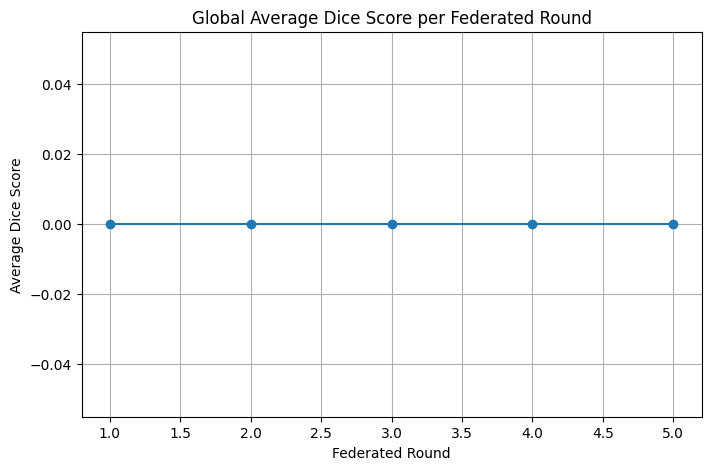

In [108]:
import matplotlib.pyplot as plt

def plot_training_progress(history):
    plt.figure(figsize=(8,5))
    plt.plot(history["round"], history["global_val_dice"], marker='o')
    plt.title("Global Average Dice Score per Federated Round")
    plt.xlabel("Federated Round")
    plt.ylabel("Average Dice Score")
    plt.grid(True)
    plt.show()

# After training
plot_training_progress(training_history)
